## Imports

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install shap
!pip install feature-engine
clear_output()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option('mode.chained_assignment',None)


import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import scipy as sp
from pathlib import Path
import plotly.express as px
from pandas_profiling import ProfileReport

from xgboost import XGBClassifier

import shap
from shap.plots._waterfall import waterfall_legacy

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder, RareLabelEncoder
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, confusion_matrix, recall_score, precision_score

from sklearn.dummy import DummyClassifier




SEED = 42
%matplotlib inline

## Functions

In [ ]:
def plot_nulls(df, figsize=(16,2), frac=1):
    g = plt.figure(figsize=figsize)
    g = sns.heatmap(df.sample(frac=frac, random_state=SEED).isnull(), cbar=False, cmap='viridis')
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', size=8)
    plt.show()
    return g

def proba_plots(df, var):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[var], ax=axs[0])
    (mu, sigma) = sp.stats.norm.fit(df[var])
    axs[0].set_title(var.capitalize())
    axs[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
    axs[1] = sp.stats.probplot(df[var], plot=plt, )
    plt.show()

def check_nulls(df, threshold=None):
    nulls = df.isna().sum()
    nulls = nulls[nulls>0]
    nulls_perc = nulls /  df.shape[0]
    if threshold is not None:
        nulls = nulls_perc[nulls_perc > threshold]

    return nulls

def cross_val_score_and_test(model, X_train, y_train, X_test, y_test, cv = 3, report=False):
    train_score = cross_val_score(estimator=model,
                                  X=X_train,
                                  y=y_train,
                                  cv=cv,
                                  scoring='accuracy')

    print('Train Accuracy - Mean: {:.3f}'.format(train_score.mean()))
    print('Train Accuracy - Std:  {:.3f}'.format(train_score.std()))

    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_preds = model.predict(X_test)
    print('Test Accuracy:  {:.3f}'.format(test_score))

    if report:
        classification_report(y_test, test_preds, 'Test Report')


def classification_report(y, p, title):

    TN, FP, FN, TP = confusion_matrix(y, p).ravel()
    f1 = f1_score(y, p)
    f2 = fbeta_score(y, p, beta=2)
    prec = precision_score(y, p)
    rec = recall_score(y, p)
    # MCC = matthews_corrcoef(y, p)
    acc = accuracy_score(y, p)
    print()
    print('#-----------------------------< ' + title + ' >-----------------------------#')
    print('n = {}\t\t\tPredicted Positive \tPredicted Negative'.format(p.shape[0]))
    print('Actually Positive\t\t{} \t\t\t{}'.format(TP, FN))
    print('Actually Negative\t\t{} \t\t\t{}'.format(FP, TN))
    print()
    print('Acc {:.3f}'.format(acc))
    print('f1 {:.3f}'.format(f1))
    print('f2 {:.3f}'.format(f2))
    print('Precision {:.3f}'.format(prec))
    print('Recall {:.3f}'.format(rec))
    # print('MCC', MCC)
    print('#-------------------------------------------------------------------------#')

    scores = {
        'TN':TN,
        'FP':FP,
        'FN':FN,
        'TP':TP,
        'f1':f1,
        'f2':f2,
        # 'MCC':MCC
    }
  
    #return scores

def get_prediction_type(y_true, y_pred):
    prediction_type = []

    for i in range(len(y_true)):
        if (y_true[i]==1 and y_pred[i] ==1):
            prediction_type.append('TP')
        elif (y_true[i]==1 and y_pred[i] ==0):
            prediction_type.append('FN')
        elif (y_true[i]==0 and y_pred[i] ==1):
            prediction_type.append('FP')
        elif (y_true[i]==0 and y_pred[i] == 0):
            prediction_type.append('TN')
    return prediction_type

## Load
Carregando as bases

In [ ]:
mt_data = pd.read_csv('metadata.csv')
df = pd.read_csv('train.csv')

## EDA

### MetaData distribution


Qualitativo nominal      51.428571
Quantitativo discreto    25.714286
Quantitativo continua    17.142857
Qualitativo ordinal       5.714286
Name: Variavel tipo, dtype: float64


<AxesSubplot:>

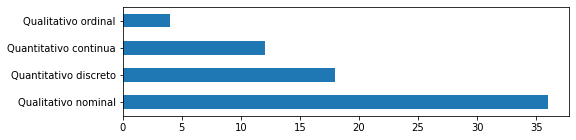

In [ ]:
ql_n = 'Qualitativo nominal'
ql_o = 'Qualitativo ordinal'
qt_d = 'Quantitativo discreto'
qt_c = 'Quantitativo continua'

print(mt_data['Variavel tipo'].value_counts(normalize = True)*100)
mt_data['Variavel tipo'].value_counts().plot(kind='barh', figsize=(8,2))

### Checando nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14123 entries, 0 to 14122
Data columns (total 70 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      14123 non-null  int64  
 1   var1    14123 non-null  int64  
 2   var2    14123 non-null  int64  
 3   var3    14123 non-null  int64  
 4   var4    14123 non-null  int64  
 5   var5    14123 non-null  int64  
 6   var6    14123 non-null  int64  
 7   var7    14123 non-null  int64  
 8   var8    14123 non-null  int64  
 9   var9    14123 non-null  int64  
 10  var10   14123 non-null  int64  
 11  var11   14123 non-null  int64  
 12  var12   14123 non-null  int64  
 13  var13   14123 non-null  int64  
 14  var14   14123 non-null  int64  
 15  var15   14123 non-null  int64  
 16  var16   14123 non-null  int64  
 17  var17   14123 non-null  int64  
 18  var18   14123 non-null  int64  
 19  var19   14123 non-null  int64  
 20  var20   14123 non-null  int64  
 21  var21   14123 non-null  int64  
 22

In [ ]:
df.describe()

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
count,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000,14123.000000
mean,17474.649366,9.712667,23.966579,1584.671245,15179.176025,5543.697869,1315.314168,-109.713729,-138.426680,-106.362388,-118.986688,13342.299865,3430.081144,1355.395454,19.480988,-65.831056,-65.180415,-84.422856,-93.522835,1059.038590,19.793670,1394.820435,3.478581,2.532890,0.958649,2.093181,-106.185867,0.370035,19.237485,3.644127,1.386887,0.036395,13.714508,3.141967,26.603413,394.255045,14.331162,7.585640,1.867025,3.592509,6.010338,3.096651,24.737025,6.855059,0.865751,0.275225,0.221624,0.049848,0.106068,0.343695,0.148340,0.055300,-85.239114,1.635276,1.519224,0.216031,-111.822517,-112.092123,-111.022124,-154.157900,-458.540340,-24.210294,0.073086,0.779221,0.028778,-862.721979,-862.762111,-41.252803,-2.154825,0.201798
std,10249.066602,7.269559,218.429664,1118.101765,9994.295223,3329.493664,1210.074896,350.202420,371.128392,311.608454,392.409936,9849.807542,3079.899094,642.799261,7.511958,307.502580,307.691935,300.502638,297.389385,537.377623,7.590808,688.872118,1.813111,1.112159,0.915563,1.388681,315.879767,0.482831,8.278536,1.062332,0.556791,0.187276,4.953779,1.992664,18.793208,181.868748,12.484156,8.723957,4.066404,1.006279,4.783179,1.029761,3.432140,4.048218,0.340932,0.914687,0.803367,0.269135,0.487567,0.474957,0.355449,0.228573,319.246246,0.749654,0.714010,0.022642,315.671274,315.799354,314.158769,361.158606,497.945633,154.485314,0.053963,0.234068,0.018681,342.956927,342.855920,199.275514,48.244171,0.401357
min,1.000000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.004267,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,8550.500000,4.000000,38.000000,731.000000,6493.500000,2374.000000,482.000000,16.000000,10.000000,1.000000,14.000000,4525.500000,914.000000,811.000000,13.000000,2.000000,3.000000,3.000000,3.000000,586.000000,13.000000,796.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,15.000000,4.000000,1.000000,0.000000,10.000000,1.000000,10.000000,255.000000,2.000000,1.000000,0.000000,4.000000,2.000000,3.000000,23.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,1.000000,1.00

df.info() informa a não existência de valores nulos na base, porém foi encontrando em diversas colunas o valor de -999. Supondo que -999 represente valores nulos, foi criado dataset que 
contém np.nan no lugar d -999 para análise de nulos

In [ ]:
df_nulos = df.replace(-999.000000, np.nan)

Grafico que apresenta os nulos caso existam, onde os valores nulos se tornam linhas amarelas no gráfico

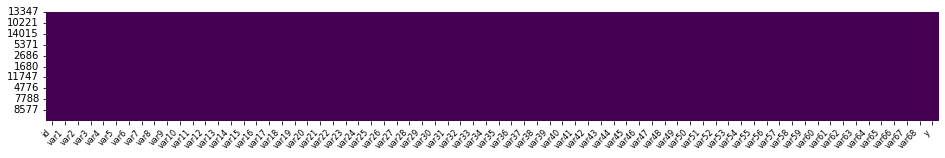

<AxesSubplot:>

In [ ]:
plot_nulls(df)



Substituindo -999 por nan para checar supostos valores nulos




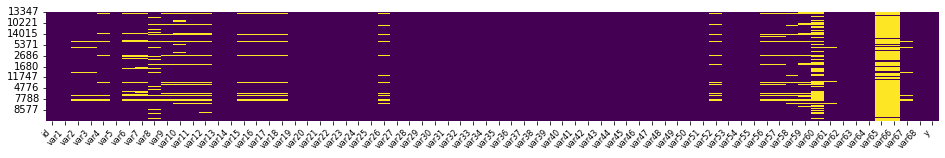

<AxesSubplot:>

In [ ]:
print('\n\nSubstituindo -999 por nan para checar supostos valores nulos\n\n')
plot_nulls(df_nulos)

Lista de colunas contendo valores nulos

In [ ]:
columns_nan = np.array(df.columns[df_nulos.isna().any()])
columns_nan

array(['var2', 'var3', 'var4', 'var6', 'var7', 'var8', 'var9', 'var10',
       'var11', 'var12', 'var15', 'var16', 'var17', 'var18', 'var26',
       'var52', 'var56', 'var57', 'var58', 'var59', 'var60', 'var61',
       'var65', 'var66', 'var67', 'var68'], dtype=object)

Porcentagem de nulos por coluna e tipo de variável de modo a entender quais colunas podem ou não ser removidas

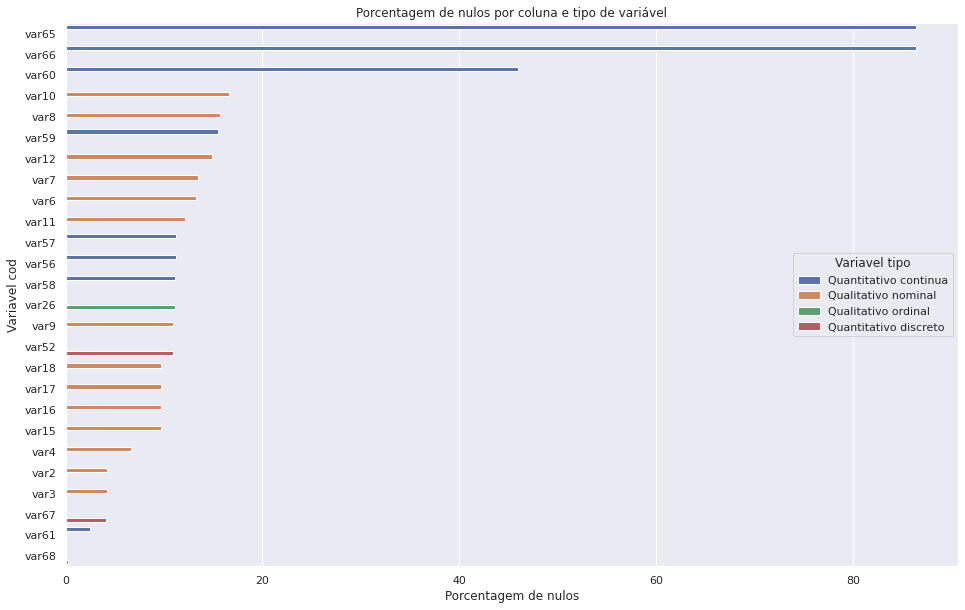

In [ ]:
nulos_type = pd.DataFrame(check_nulls(df_nulos, 0) ).reset_index()
nulos_type.columns = ['Variavel cod', 'Porcentagem de nulos']
nulos_type = pd.merge(nulos_type, mt_data, on = 'Variavel cod', how = 'left')
nulos_type['Porcentagem de nulos'] = nulos_type['Porcentagem de nulos']*100
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.barplot(data = nulos_type.sort_values('Porcentagem de nulos', ascending = False), x = nulos_type.columns[1], y = nulos_type.columns[0], hue = 'Variavel tipo')
ax.set_title('Porcentagem de nulos por coluna e tipo de variável')
plt.show()

### Checking outliers

Visualização de boxplot das variáveis por tipo para observação de outliers.

As variáveis do tipo quantitativa discreta, qualitativa ordinal e qualitativa nominal foram normalizadas de maneira a se observar melhor devido a diferença entre as escalas das colunas

Boxplot das variávies do tipo quantitativa discreta

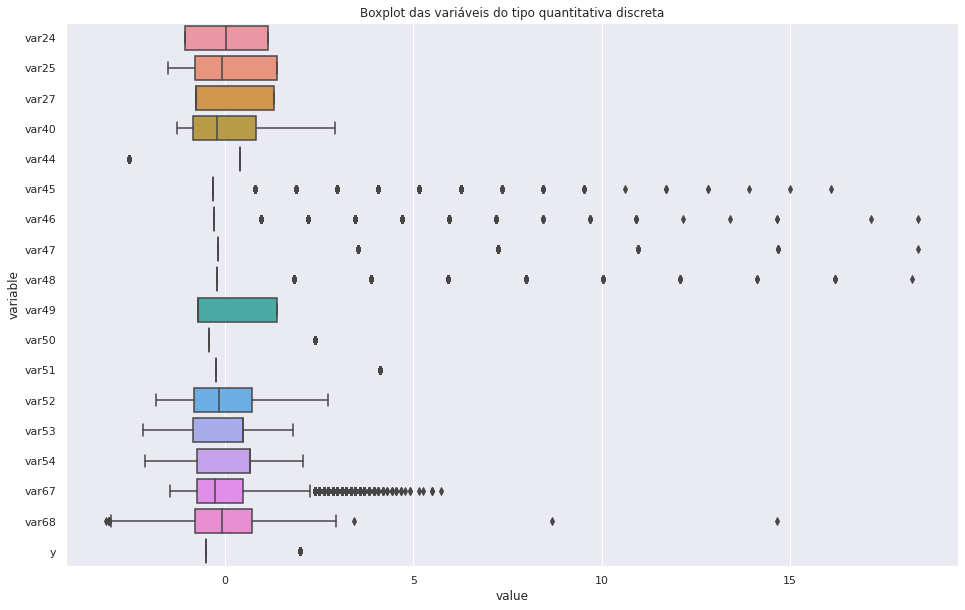

In [ ]:
df_qtd = df_nulos.drop(mt_data[mt_data[mt_data.columns[-1]] != qt_d][mt_data.columns[0]], axis = 1)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.boxplot(x="value", y="variable", data=pd.melt((df_qtd-df_qtd.mean())/df_qtd.std()))
ax.set_title('Boxplot das variáveis do tipo quantitativa discreta')
plt.show()

Boxplot das variáveis do tipo quantitativa contínua

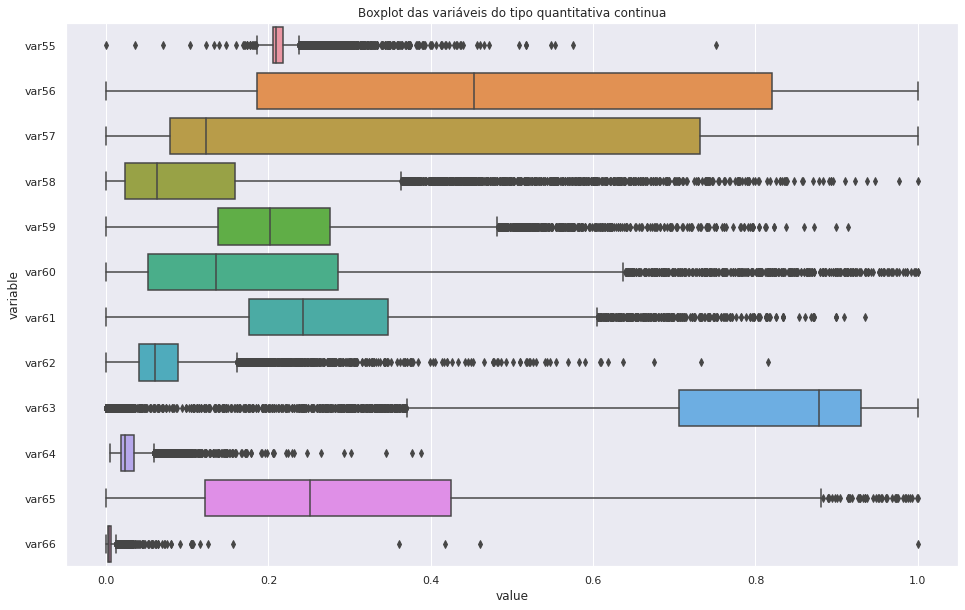

In [ ]:
df_qtc = df_nulos.drop(mt_data[mt_data[mt_data.columns[-1]] != qt_c][mt_data.columns[0]], axis = 1)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.boxplot(x="value", y="variable", data=pd.melt(df_qtc))
ax.set_title('Boxplot das variáveis do tipo quantitativa continua')
plt.show()

Boxplot das variáveis do tipo qualitativa nominal

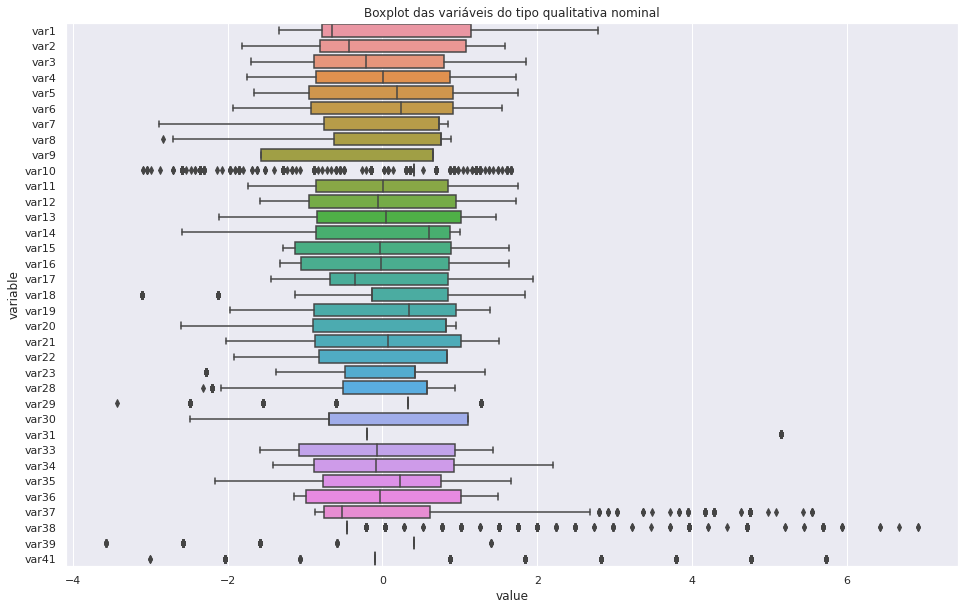

In [ ]:
df_qln = df_nulos.drop(list(mt_data[mt_data[mt_data.columns[-1]] != ql_n][mt_data.columns[0]]) + ['id'] , axis = 1)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.boxplot(x="value", y="variable", data=pd.melt((df_qln-df_qln.mean())/df_qln.std()))
ax.set_title('Boxplot das variáveis do tipo qualitativa nominal')
plt.show()

Boxplot das variáveis do tipo qualitativa ordinal

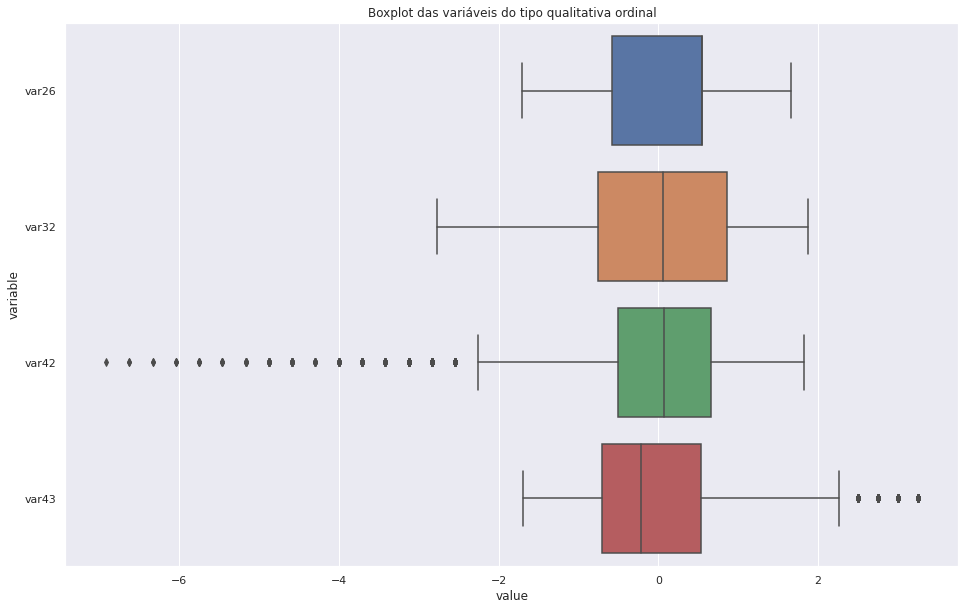

In [ ]:
df_qlo = df_nulos.drop(list(mt_data[mt_data[mt_data.columns[-1]] != ql_o][mt_data.columns[0]]) + ['id'] , axis = 1)
sns.set(rc={'figure.figsize':(16,10)})
ax = sns.boxplot(x="value", y="variable", data=pd.melt((df_qlo-df_qlo.mean())/df_qlo.std()))
ax.set_title('Boxplot das variáveis do tipo qualitativa ordinal')
plt.show()

### Quantitativa contínua


Removendo varíaveis com valores nulos para análise de distribuição

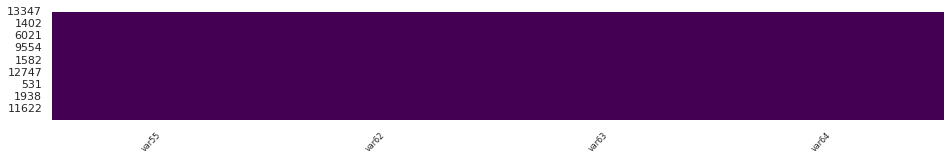

<AxesSubplot:>

In [ ]:
var_null_qt_c = ['var65', 'var66', 'var60', 'var59', 'var57', 'var56', 'var58', 'var61']

df_qt_c = df_nulos.drop(mt_data[mt_data[mt_data.columns[-1]] != qt_c][mt_data.columns[0]], axis = 1)
df_qt_c = df_qt_c.drop(var_null_qt_c, axis = 1)
plot_nulls(df_qt_c)

Análise da distribuição das variáveis não nulas de modo a compreender o tipo de distribuição dessas variáveis

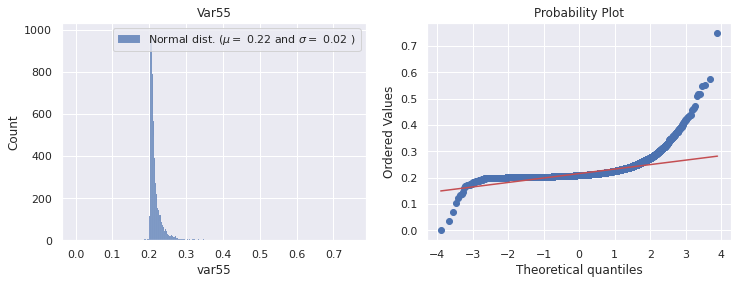

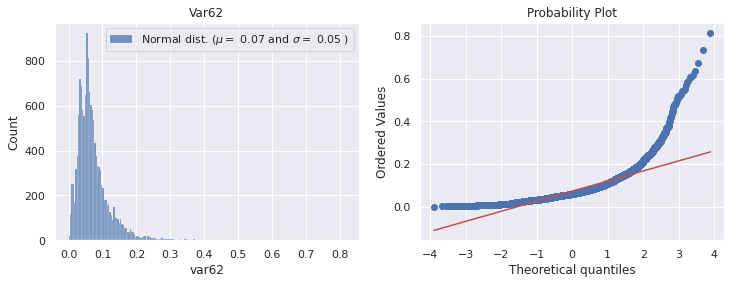

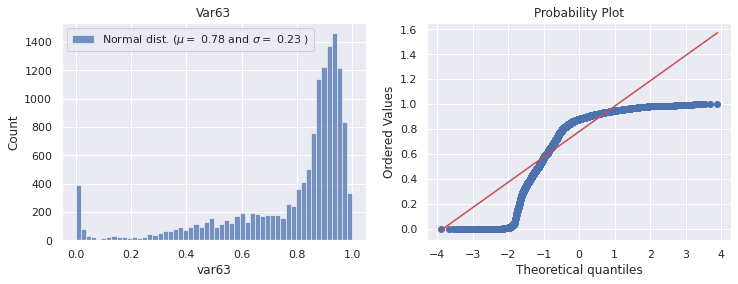

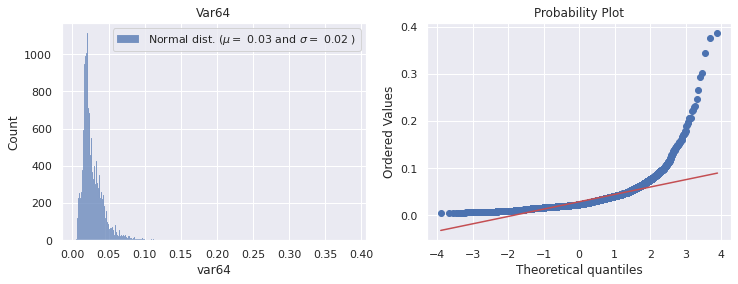

In [ ]:
for column in df_qt_c.columns:
  proba_plots(df_qt_c, column)

Análise de correlação das variáveis usando um método não paramétrico


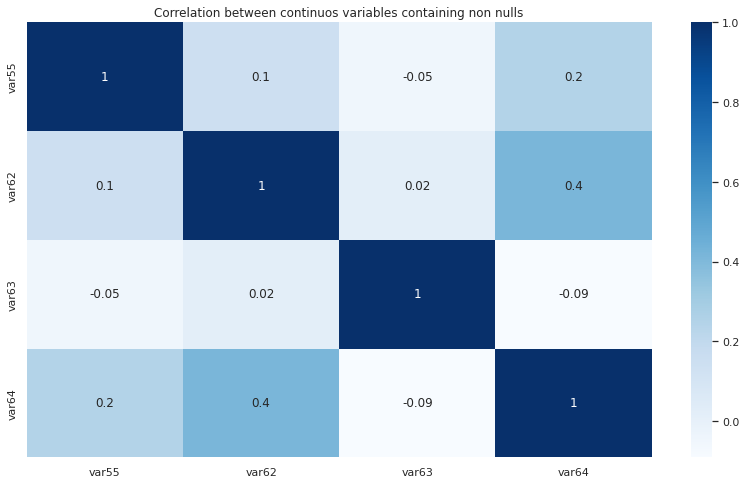

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_qt_c.corr(method = 'spearman') # USE spearman or kendall
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
heatmap.set_title('Correlation between continuos variables containing non nulls')
plt.show()

Jointplot apresentando um scatter e um histograma da distribuição por classe e colunas com maior grau de correlação positiva, que apresenta uma não linearidade nas classes e uma semelhança no histograma das distribuições de ambas as classes

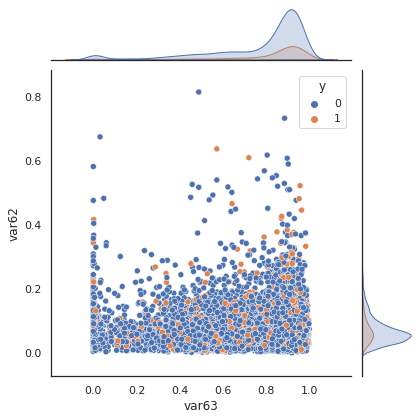

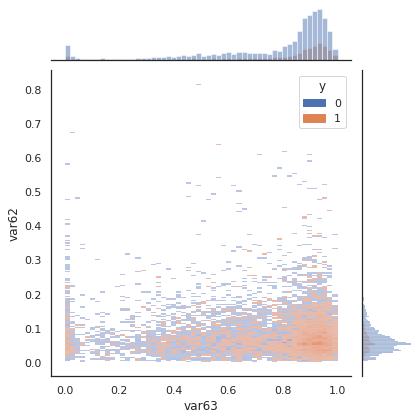

In [ ]:
sns.jointplot(data=df, x='var63', y='var62', hue='y')
sns.jointplot(data=df, x='var63', y='var62', hue='y', kind ='hist')
plt.show()

### Quantitativa discreta

Removendo colunas com valores nulos para análise de distribuição do tipo quantitiva discreta

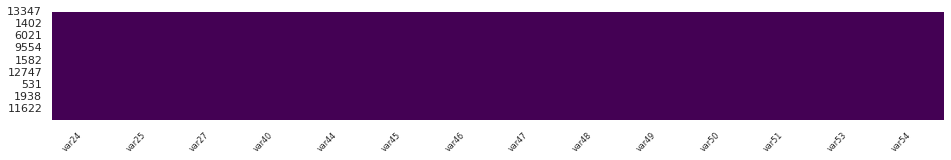

<AxesSubplot:>

In [ ]:
var_null_qt_d = ['var52', 'var67', 'var68', 'y']

df_qt_d = df_nulos.drop(mt_data[mt_data[mt_data.columns[-1]] != qt_d][mt_data.columns[0]], axis = 1)
df_qt_d = df_qt_d.drop(var_null_qt_d, axis = 1)
plot_nulls(df_qt_d)

Gráficos apresentando a distribuição das variáveis do tipo quantitativa discreta

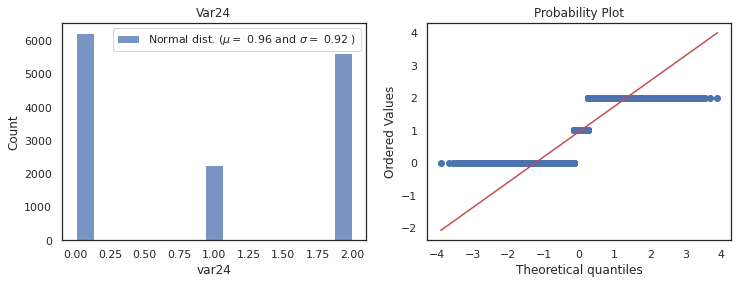

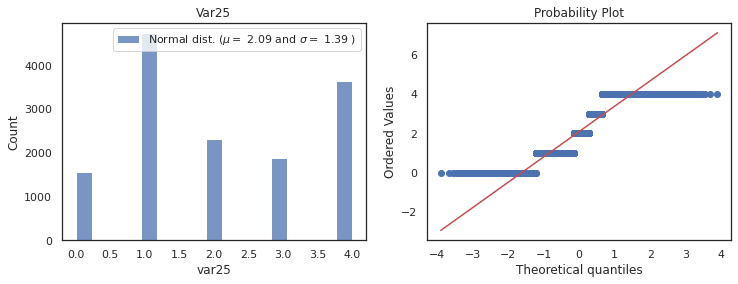

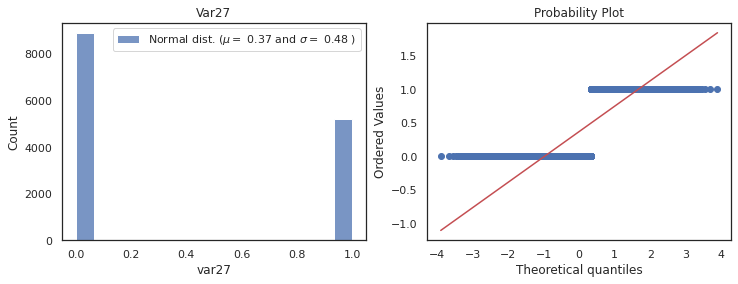

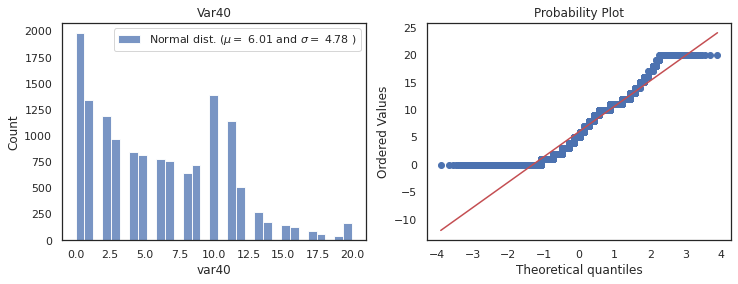

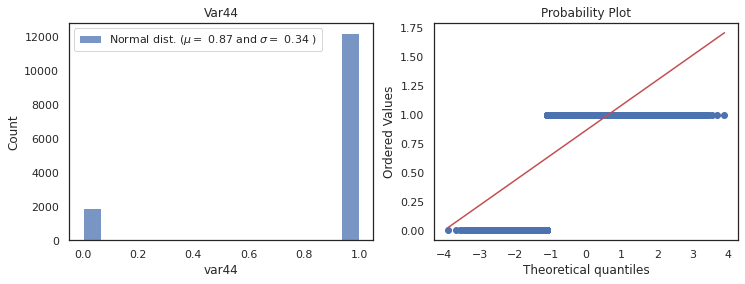

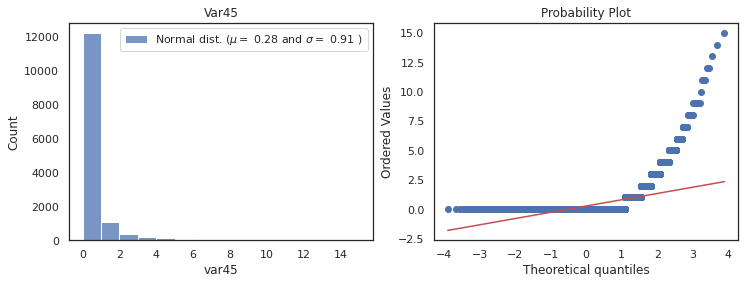

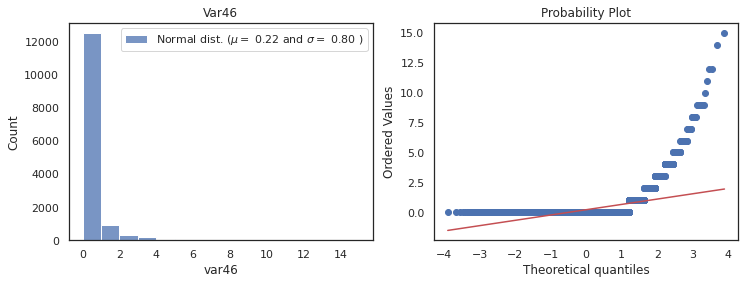

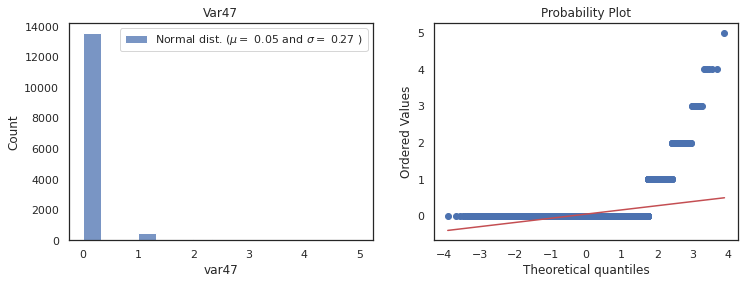

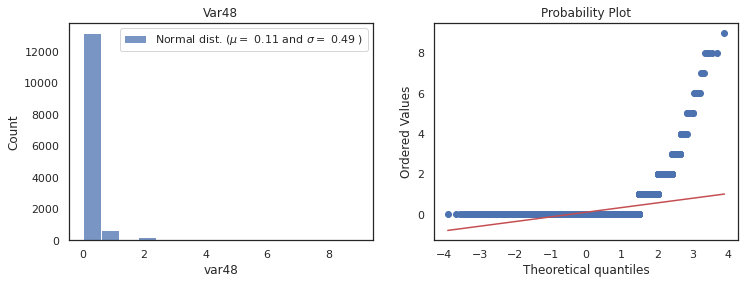

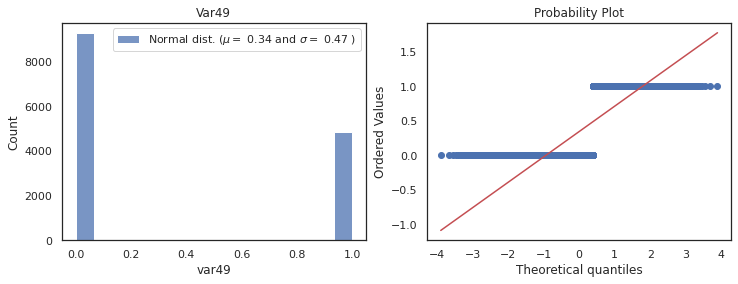

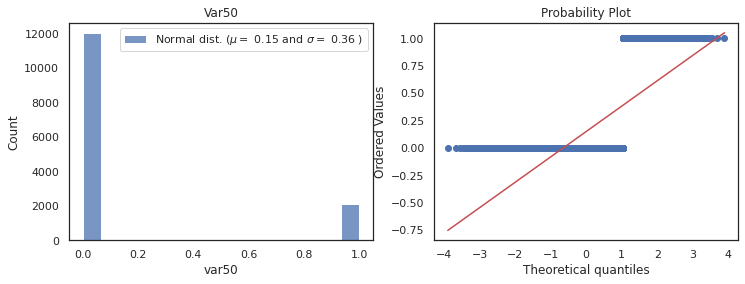

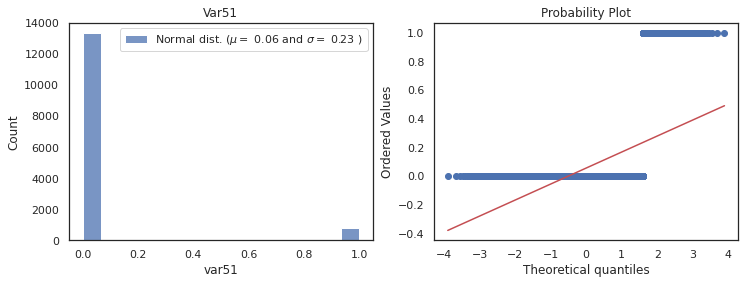

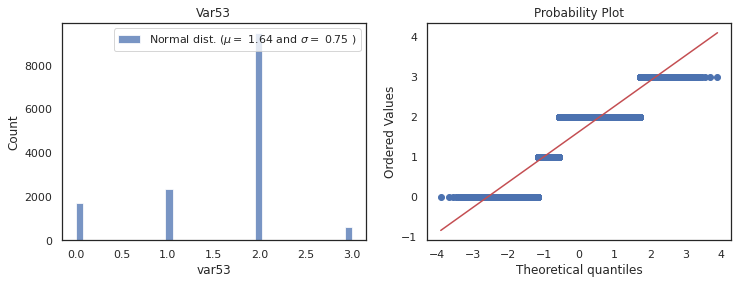

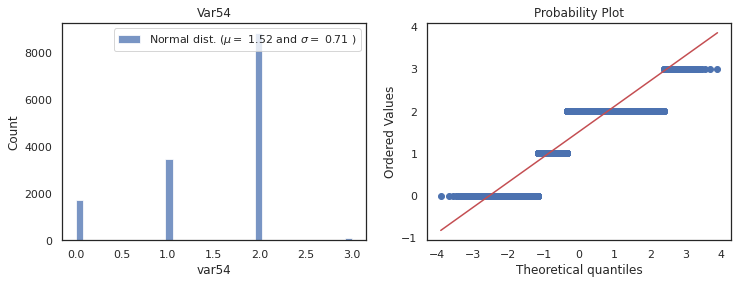

In [ ]:
for column in df_qt_d.columns:
  proba_plots(df_qt_d, column)

Gráfico de correlação entre as variáveis

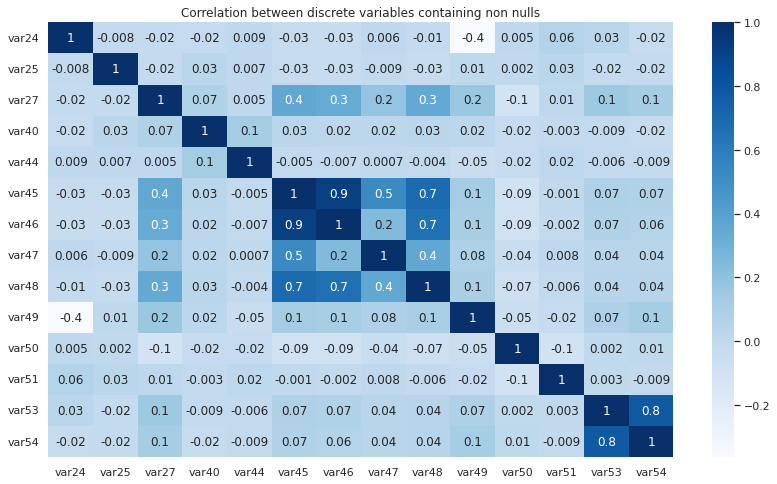

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_qt_d.corr(method = 'spearman') # USE spearman or kendall
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
heatmap.set_title('Correlation between discrete variables containing non nulls')
plt.show()

### Correlação quantitativa discreta + quantitativa contínua

Gráfico que apresenta a correlação entre as variáveis quantitativas, sejam discretas ou contínuas

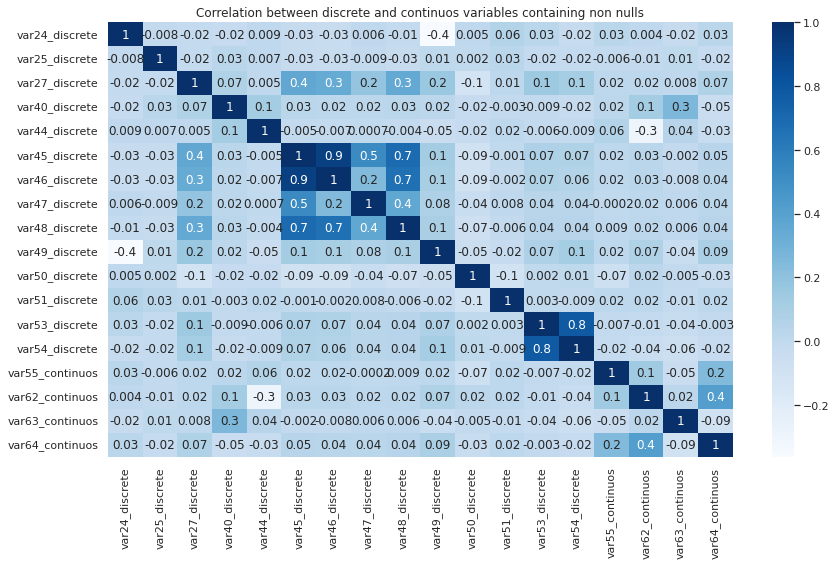

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")

new_qt_d = df_qt_d.copy()
new_qt_d.columns = [column + '_discrete' for column in new_qt_d.columns]

new_qt_c = df_qt_c.copy()
new_qt_c.columns = [column + '_continuos' for column in new_qt_c.columns]

corr = pd.concat([new_qt_d, new_qt_c], axis = 1).corr(method = 'spearman') # USE spearman or kendall
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
heatmap.set_title('Correlation between discrete and continuos variables containing non nulls')
plt.show()

### PCA visualization

Uso da técnica de PCA para uma tentativa de visualização dos dados em um scatterplot de modo a se compreender como se comportam espacialmente as classes

#### Removendo coluna com valores nulos ( valores contendo valor -999 )

Removendo as colunas com os valores nulos esse é o resultado obtido, resultado com baixa variância o que causa baixa confiabilidade, porém se mantém o padrão encontrado em outros scatterplot de semelhança entre as distribuições das classes e a não linearidade dos dados

Variância:
[10.18093918  7.3481819 ]



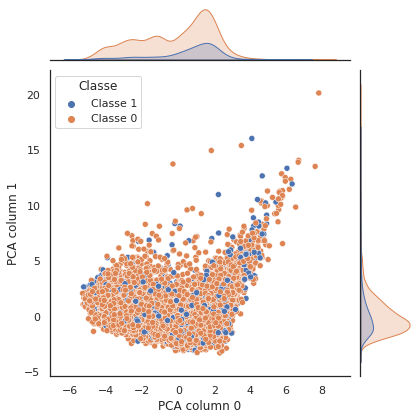

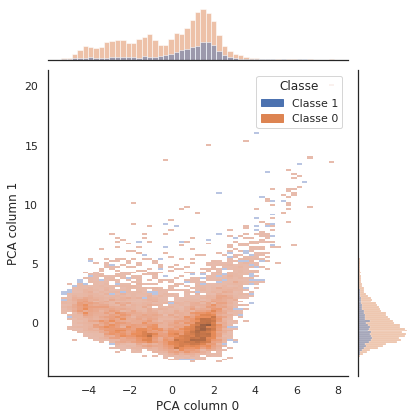

In [ ]:
pca = PCA(n_components = 2)

drop_columns = np.append(columns_nan, ['id', 'y'])
df_no_nulls = df.drop(drop_columns, axis = 1)

pipe_pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
pca_df_no_nulss = pipe_pca.fit_transform(df_no_nulls)

print('Variância:')
print(pca.explained_variance_ratio_*100)
print()

pca_df_no_nulss = pd.DataFrame(pca_df_no_nulss)
pca_df_no_nulss['Classe'] = df.y
pca_df_no_nulss.columns = ['PCA column 0', 'PCA column 1', 'Classe']
pca_df_no_nulss.Classe = pca_df_no_nulss.Classe.apply(lambda x: 'Classe 1' if x == 1 else 'Classe 0')



sns.jointplot(data=pca_df_no_nulss, x='PCA column 0', y='PCA column 1', hue='Classe')
sns.jointplot(data=pca_df_no_nulss, x='PCA column 0', y='PCA column 1', hue='Classe', kind = 'hist')
#jt.set(title = 'Distribuição das classes após PCA')
plt.show()

#### Não removendo colunas com valores nulos

Resultado não removendo os valores nulos, utilizando os valores -999 e todas as colunas. 

Maior variância e diferença no gráfico, porém ainda se mantém o padrão da não linearidade e semelhança de distribuição

Variância:
[19.31390032  6.82546321]



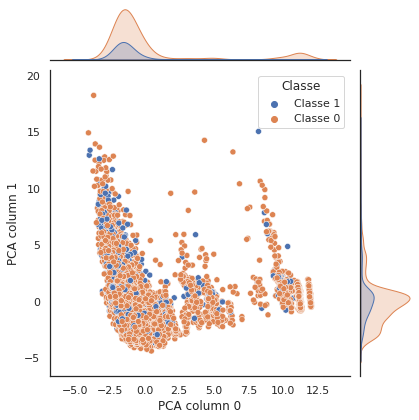

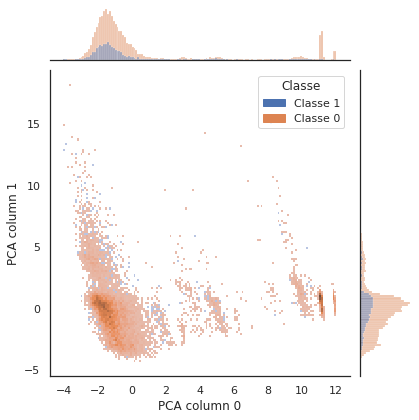

In [ ]:
df_nulls = df.drop(['id', 'y'], axis = 1)

pipe_pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
pca_df_nulss = pipe_pca.fit_transform(df_nulls)

print('Variância:')
print(pca.explained_variance_ratio_*100)
print()

pca_df_nulss = pd.DataFrame(pca_df_nulss)
pca_df_nulss['Classe'] = df.y
pca_df_nulss.columns = ['PCA column 0', 'PCA column 1', 'Classe']
pca_df_nulss.Classe = pca_df_nulss.Classe.apply(lambda x: 'Classe 1' if x == 1 else 'Classe 0')

sns.jointplot(data=pca_df_nulss, x='PCA column 0', y='PCA column 1', hue='Classe')
sns.jointplot(data=pca_df_nulss, x='PCA column 0', y='PCA column 1', hue='Classe', kind = 'hist')
#jt.set(title = 'Distribuição das classes após PCA')
plt.show()

## Feature selection

Utilização do algoritmo random forest para escolha das melhores features e análise a partir do uso do SHAp

Removendo colunas com mais de 40% de valores nulos (Considere nulo -999)

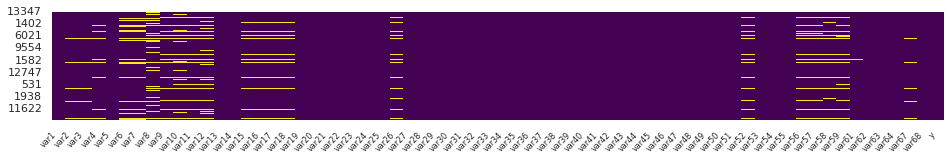

<AxesSubplot:>

In [ ]:
columns_above_40 = ['var60', 'var65', 'var66']
df_fe = df.drop(columns_above_40 + ['id'], axis = 1) #
plot_nulls(df_fe.replace(-999.0000, np.nan))

### Distribution/train and test division

Apresentação da distribuição dos dados em relação a classe e divisão estratificada

0    79.820152
1    20.179848
Name: y, dtype: float64


<AxesSubplot:>

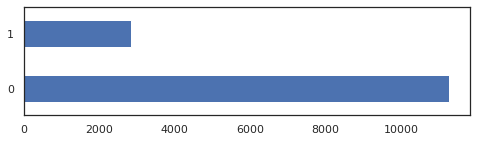

In [ ]:
print(df_fe.y.value_counts(normalize = True)*100)
df_fe.y.value_counts().plot(kind='barh', figsize=(8,2))

In [ ]:
X = df_fe.iloc[:, :-1]
y = df_fe.iloc[:, -1:]

split_rate = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=SEED, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11298, 65), (2825, 65), (11298, 1), (2825, 1))

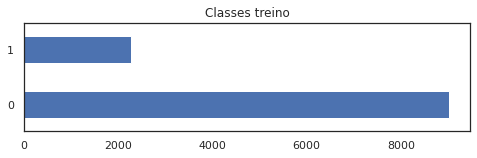

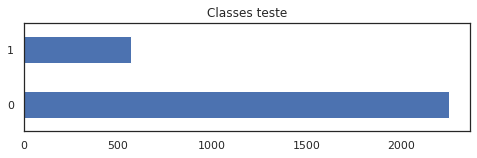

In [ ]:
y_train.y.value_counts().plot(kind='barh', figsize=(8,2), title = 'Classes treino')
plt.show()
y_test.y.value_counts().plot(kind='barh', figsize=(8,2), title = 'Classes teste')
plt.show()

### Dummy classifier
Análise de um dummy classifier para descartar a possibilidade do acaso

In [ ]:
cv = 10
report = True
strategy_type = 'stratified'


model = DummyClassifier(strategy=strategy_type, random_state=SEED)
cross_val_score_and_test(model, X_train, y_train, X_test, y_test, cv = cv, report = report)

Train Accuracy - Mean: 0.672
Train Accuracy - Std:  0.006
Test Accuracy:  0.678

#-----------------------------< Test Report >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		118 			452
Actually Negative		458 			1797

Acc 0.678
f1 0.206
f2 0.207
Precision 0.205
Recall 0.207
#-------------------------------------------------------------------------#


### Random Forest

Criação dos parâmetros para o random grid do Random Forest

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [10, 32, 55, 77, 100],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10,
  17,
  24,
  31,
  38,
  45,
  52,
  60,
  67,
  74,
  81,
  88,
  95,
  102,
  110,
  None],
 'min_samples_split': [2, 5, 10, 20],
 'min_samples_leaf': [1, 2, 4, 6, 8],
 'bootstrap': [True, False]}

Aplicando cross validation utilizando os parâmetros do random grid para a escolha do melhor modelo no conjunto de validação para ser aplicado no conjunto de teste

In [ ]:
n_iter = 10
cv = 10
verbose = 1
n_jobs = -1



model = RandomForestClassifier(random_state=SEED)
model_grid = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = n_iter, cv = cv, verbose=verbose, random_state=SEED, n_jobs = n_jobs)

#GridSearchCV(estimator = model, param_grid = random_grid, cv = cv, verbose = verbose, n_jobs = n_jobs)

# Fit the random search model
model_grid.fit(X_train, y_train)

best_model = model_grid.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Report dos resultados obtidos no conjunto de teste

In [ ]:
y_true = np.array(y_test)
y_pred = best_model.predict(X_test)
classification_report(y_true, y_pred, 'Test Report')


#-----------------------------< Test Report >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		276 			294
Actually Negative		86 			2169

Acc 0.865
f1 0.592
f2 0.522
Precision 0.762
Recall 0.484
#-------------------------------------------------------------------------#


### Feature importance

#### MDI

Utilização do MDI para análise de feature importance do modelo

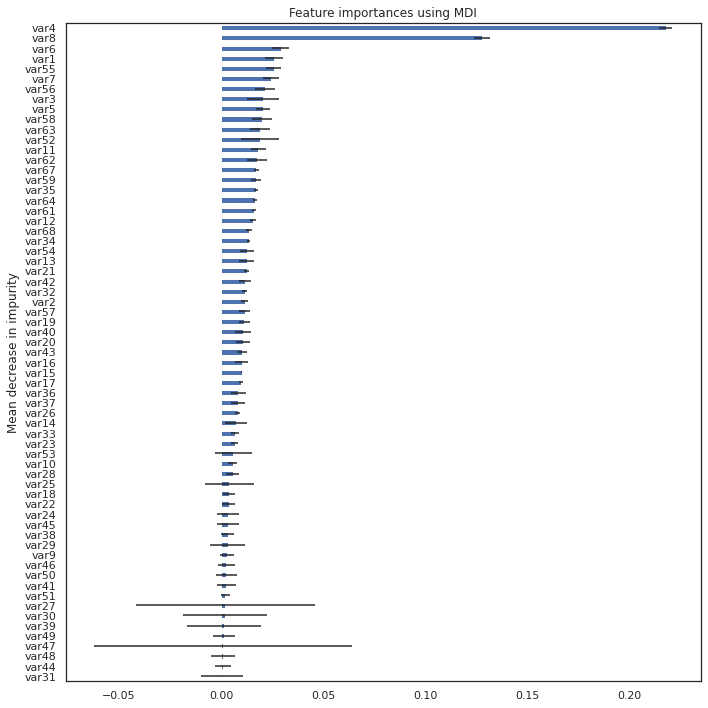

In [ ]:
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_train.columns)
# forest_importances.sort_values(ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))
forest_importances.sort_values(ascending = True).plot.barh(xerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Shap values

Utilização do shap values para análise do resultado do modelo

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


Gráfico que apresenta as variáveis mais importantes e sua influência para a predição da classe positiva ou negativa

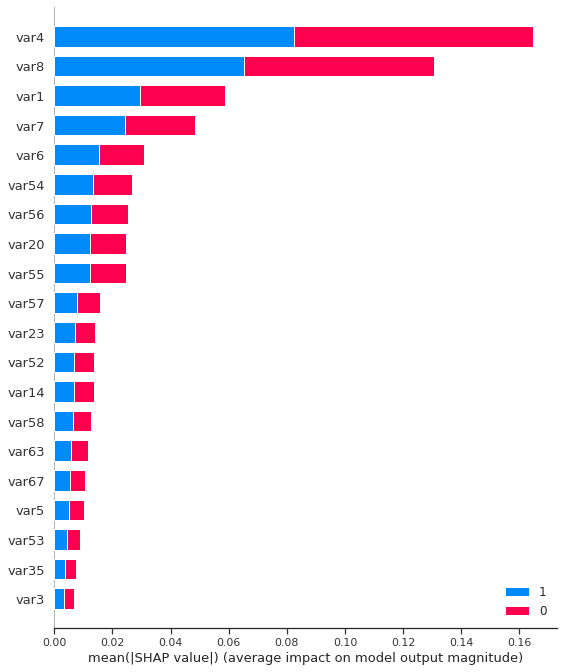

In [ ]:
shap.summary_plot(shap_values, X_test, class_names=best_model.classes_)

Uma breve análise do resultado obtido no shap mostra as variáveis com maior relevância e o quanto valores altos ou baixos influenciaram na decisão do modelo por classe.

A variável 8 por exemplo apresentou os resultados bem divididos em relação a o quanto o valor da variávei influencia para classe positiva ou negativa, mostrando que valores mais baixos influenciaram mais para a classe positiva enquanto que valores mais altos influenciaram mais para a classe negativa.

O padrão se repete para outras variáveis em diferentes intensidades e em alguns casos não tão nitidamentes divididos.

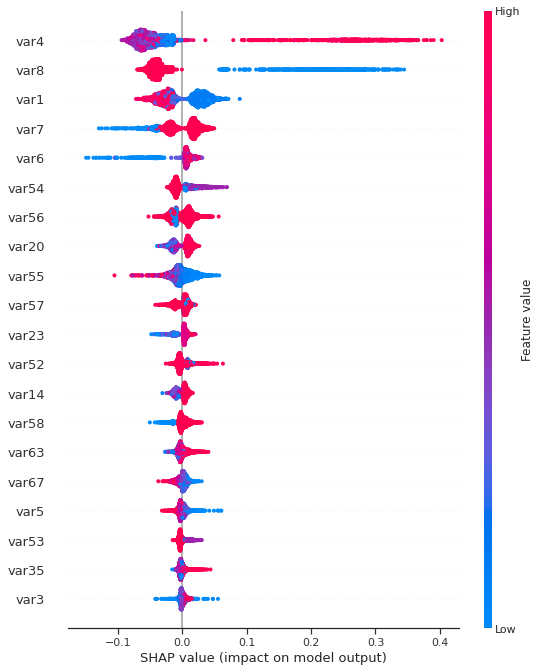

In [ ]:
shap.summary_plot(shap_values[1], X_test)

## Machine Learning

### Pre processing

Criação de base contendo somente as melhores features encontradas

In [ ]:
features_use = ['var4', 'var8', 'var1', 'var7', 'var6', 'var54', 'var56', 'var20', 'var55']
drop_columns_fe = [column for column in df.columns if column not in features_use]

df_best = df.drop(drop_columns_fe[:-1], axis = 1)

df_best.head()

,var1,var4,var6,var7,var8,var20,var54,var55,var56,y
0,18,29442,2435,35,-999,26,1,0.212414,0.137,1
1,4,13684,-999,-999,17,16,1,0.228784,0.308,0
2,0,10232,791,16,-999,10,1,0.204636,0.213,0
3,20,2689,1042,13,10,8,1,0.208299,0.716,0
4,7,29428,304,16,-999,10,1,0.222896,0.596,1


In [ ]:
X = df_best.iloc[:, :-1]
y = df_best.iloc[:, -1:]

split_rate = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=SEED, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11298, 9), (2825, 9), (11298, 1), (2825, 1))

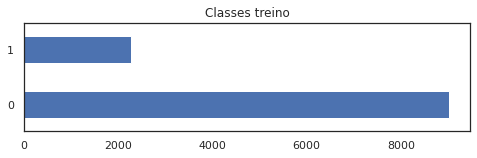

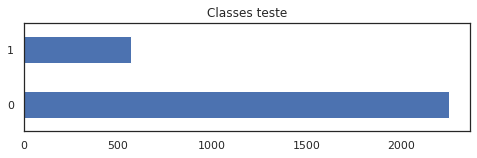

In [ ]:
y_train.y.value_counts().plot(kind='barh', figsize=(8,2), title = 'Classes treino')
plt.show()
y_test.y.value_counts().plot(kind='barh', figsize=(8,2), title = 'Classes teste')
plt.show()

### Dummy classifier para o modelo utilizando as melhores features


In [ ]:
cv = 10
report = True
strategy_type = 'stratified'


model = DummyClassifier(strategy=strategy_type, random_state=SEED)
cross_val_score_and_test(model, X_train, y_train, X_test, y_test, cv = cv, report = report)

Train Accuracy - Mean: 0.672
Train Accuracy - Std:  0.006
Test Accuracy:  0.678

#-----------------------------< Test Report >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		118 			452
Actually Negative		458 			1797

Acc 0.678
f1 0.206
f2 0.207
Precision 0.205
Recall 0.207
#-------------------------------------------------------------------------#


### Traning models

#### Dicionário de parâmetros

In [ ]:
# xgb_parameters
xgb_parameters = {
    'n_estimators':[100, 150, 200], 
    'max_depth':[3,7, 10], 
    'learning_rate':[0.1, .01], 
}

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 3)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 8)]
max_depth.append(None)
min_samples_split = [2, 15]
min_samples_leaf = [1, 6]
bootstrap = [True, False]

rf_parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


mlp_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

ada_parameters = {
    'n_estimators': [2, 8, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 3)],
    'algorithm': ['SAMME', 'SAMME.R']
}


#### Treinando modelos

In [ ]:
n_iter = 18
cv = 10
verbose = 1
n_jobs = -1

# instanciar modelos e randomsearch
# xgb

xgb_model = XGBClassifier(objective= 'binary:logistic',nthread=4,seed=SEED)
xgb_r_model = RandomizedSearchCV(estimator = xgb_model, param_distributions = xgb_parameters, scoring = 'precision',  n_iter = n_iter, cv = cv, verbose=verbose, random_state=SEED, n_jobs = n_jobs)
xgb_r_model.fit(X_train, y_train)
xgb_best = xgb_r_model.best_estimator_


# #ada
ada = AdaBoostClassifier()
ada_r = RandomizedSearchCV(estimator = ada, param_distributions = ada_parameters, scoring = 'precision', n_iter = n_iter, cv = cv, verbose=verbose, random_state=SEED, n_jobs = n_jobs)
ada_r.fit(X_train, y_train)
ada_best = ada_r.best_estimator_

# #RandomForest
rf = RandomForestClassifier(random_state=SEED)
rf_r = RandomizedSearchCV(estimator = rf, param_distributions = rf_parameters, scoring = 'precision',  n_iter = n_iter, cv = cv, verbose=verbose, random_state=SEED, n_jobs = n_jobs)
rf_r.fit(X_train, y_train)
rf_best = rf_r.best_estimator_


# Não utilizei a mlp devido ao tempo de treinamento ser impraticavel para o colab
#MLP
#mlp = MLPClassifier()
#mlp_r = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_parameters, n_iter = n_iter, cv = cv, verbose=verbose, random_state=SEED, n_jobs = n_jobs)

#mlp transformação dados
#scaler = StandardScaler()
#X_train_mlp = scaler.fit_transform(X_train, y_train)

#mlp_r.fit(X_train_mlp, y_train)
#mlp_best = mlp_r.best_estimator_


clear_output()


#### Precision metric analyss

A métrica precisão foi escolhida na premissa de que o melhor modelo gerado para esse caso seria um modelo que gera a menor quantidade de falsos positivos e consequentemente um menor número de tentativas de contato com clientes não interessados, fazendo com que quanto melhor o resultado da métrica de precisão melhor o modelo para o problema.

Foi gerado um conjunto de 18 resultados por modelo (Cada resultado é uma combinação diferente de parâmetros), onde a distribuição dos dados é apresentada abaixo para a decisão de qual teste estátistico utilizar para a validação da hipotese nula em relação aos resultados dos modelos treinados

Valor médio do precision: 72.04


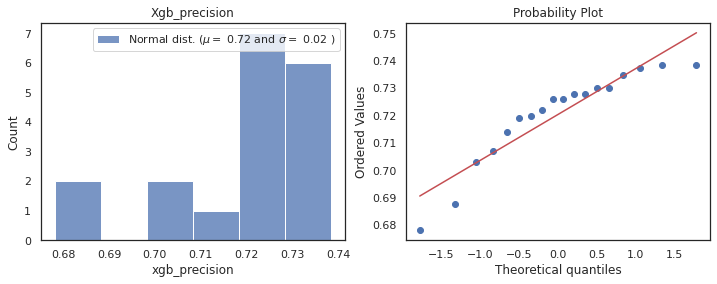




Valor médio do precision: 68.74


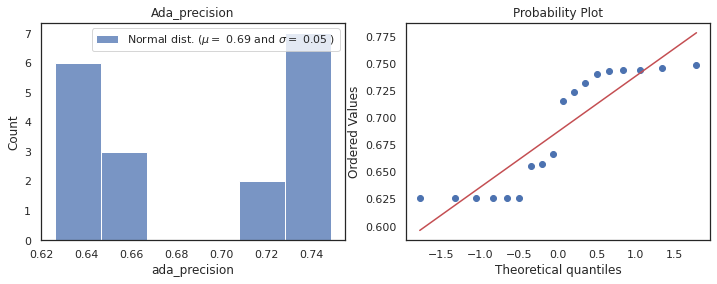




Valor médio do precision: 72.63


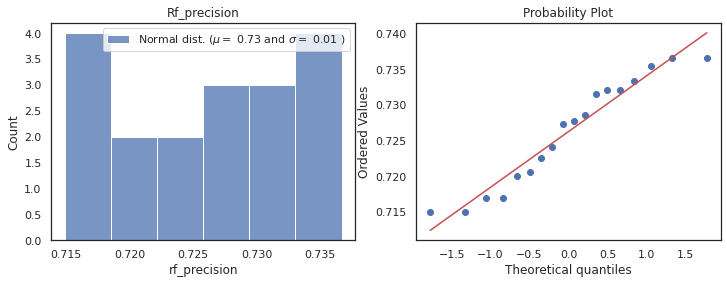

In [ ]:
precisions_means = [xgb_r_model.cv_results_['mean_test_score'],
                    ada_r.cv_results_['mean_test_score'],
                    rf_r.cv_results_['mean_test_score']]

df_prec = pd.DataFrame(precisions_means).T
df_prec.columns = ['xgb_precision', 'ada_precision', 'rf_precision']

for i, name in enumerate(df_prec.columns):
  print('Valor médio do precision: {:.2f}'.format(np.mean(precisions_means[i])*100))
  proba_plots(df_prec, name)
  print('\n\n')

Utilização de um teste estátistico não paramétrico devido ao tipo de distribuição dos resultados não ser uma distribuição normal

In [ ]:
s, p = sp.stats.kruskal(*precisions_means)
if p < 0.05:
  print('Hipotese nula rejeitada\nValor de p:', str(p))
else:
  print('Hipotese nula verdadeira\nValor de p:', str(p))

Hipotese nula verdadeira
Valor de p: 0.5035396241340783


### Avaliação dos modelos

In [ ]:
xgb_predito = xgb_best.predict(X_test)
ada_predito = ada_best.predict(X_test)
rf_predito = rf_best.predict(X_test)

#### Report dos modelos no conjunto de teste

Os reports abaixo mostram os resultados obtidos no conjunto de teste pelos melhores modelos no cross validation e na otimização de parametros.

O algoritmo Ada teve o melhor resultado na métrica de precision, enquanto que o XGb teve o melhor resultado na metrica de recall, fazendo com que dependendo da preferência em relação a quantidade de falsos positivos gerados ou a quem acertou mais verdadeiros positivos vai definir qual o melhor algoritmo para ser utilizado.

No caso do Ada o número de tentativas de contato com clientes não interessados é diminuído, porém há uma maior perda de possíveis clientes interessados em comparação com o Xgb, o que se explica pela diferença nos valores do precision ( Precisão em que o modelo disse que era da classe positiva e realmente era ) e o Recall ( O quanto dos positivos no total o modelo acertou )

In [ ]:
classification_report(np.array(y_test), xgb_predito, 'Test Report Xgb')


#-----------------------------< Test Report Xgb >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		299 			271
Actually Negative		119 			2136

Acc 0.862
f1 0.605
f2 0.554
Precision 0.715
Recall 0.525
#-------------------------------------------------------------------------#


In [ ]:
classification_report(np.array(y_test), ada_predito, 'Test Report Ada')


#-----------------------------< Test Report Ada >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		288 			282
Actually Negative		99 			2156

Acc 0.865
f1 0.602
f2 0.540
Precision 0.744
Recall 0.505
#-------------------------------------------------------------------------#


In [ ]:
classification_report(np.array(y_test), rf_predito, 'Test Report Random Forest')


#-----------------------------< Test Report Random Forest >-----------------------------#
n = 2825			Predicted Positive 	Predicted Negative
Actually Positive		290 			280
Actually Negative		108 			2147

Acc 0.863
f1 0.599
f2 0.541
Precision 0.729
Recall 0.509
#-------------------------------------------------------------------------#
